# *Saad El Dine Ahmed    7370*
# Assignment 1
## Surviving a meteor strike

- Scientific prediction

![meteor](https://github.com/goodboychan/goodboychan.github.io/blob/main/_notebooks/image/meteor.png?raw=1)


## **My Modifications:**
* Data Augmentation: Added jittering, scaling, and noise to the y positions to
augment the data.
* Optimizing Network Architecture: Increased the number of neurons in each layer to 128,64,32,16 and added dropout layers to prevent overfitting.
* Applying Advanced Regularization Techniques: Added L2 regularization to the last dense layer to prevent overfitting.
* Fine-tuning Hyperparameters: Increased the number of epochs to 200 to further optimize the network architecture and fine-tune the hyperparameters.
* Implementing Effective Training Methodologies: Used early stopping to prevent overfitting and improve training efficiency.
* Utilizing Ensemble Techniques: Trained multiple models (5 in this case) and averaged their predictions to improve accuracy.
* Storing the Best Model: Kept track of the validation loss for each model and stored the model with the lowest validation loss as the best model.
* Plotting Orbits: Modified the plotting function to plot the orbits of the ensemble, the prediction of the best model, the prediction of the basic model, and the scientific data on the same plot.


## Import Required Libraries

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import regularizers
from google.colab import files
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

uploaded = files.upload()
plt.rcParams['figure.figsize'] = (8, 8)

Saving orbit.csv to orbit (1).csv


## Load Data

In [166]:
data = pd.read_csv("orbit.csv")

# Print the data to verify it's loaded correctly
data.head()

,time_steps,y
0,-10.000000,100.000000
1,-9.989995,99.800000
2,-9.979990,99.600200
3,-9.969985,99.400601
4,-9.959980,99.201201


## Seperate data to numpy array

In [167]:
time_steps = data['time_steps'].to_numpy()
y_positions = data['y'].to_numpy()

In [168]:
# Data augmentation: add jittering, scaling, and noise
jitter = np.random.normal(loc=0, scale=0.05, size=len(data))
scaled = np.random.uniform(low=0.9, high=1.1, size=len(data))
noise = np.random.normal(loc=0, scale=0.1, size=len(data))

# Apply augmentation to y_positions
y_positions_augmented = data['y'].to_numpy() * scaled + jitter + noise

# Combine original and augmented data
time_steps = np.concatenate([data['time_steps'].to_numpy(), data['time_steps'].to_numpy()])
y_positions = np.concatenate([data['y'].to_numpy(), y_positions_augmented])

# Shuffle the data
shuffle_idx = np.random.permutation(len(time_steps))
time_steps = time_steps[shuffle_idx]
y_positions = y_positions[shuffle_idx]

##Build the model (Try to change nb of units, nb of layers, adding dropout layers)

In [177]:
# Instantiate a Sequential model
model = Sequential()

# Add a Dense layer with 128 neurons and an input of 1 neuron
model.add(Dense(128, input_shape=(1,), activation='relu'))

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

# End your model with a Dense layer and no activation
model.add(Dense(1))
early_stopping = EarlyStopping(monitor='val_loss', patience=13, restore_best_weights=True)

##Compile the model

In [183]:
# Compile your model
model.compile(optimizer='adam', loss='mse')

print('Training started..., this can take a while:')

Training started..., this can take a while:


##Train and Evalute the model

In [184]:
# Fit model on your data
model.fit(time_steps, y_positions, epochs=200, validation_split=0.2, callbacks=[early_stopping])

# Evaluate your model
print("Final loss value:", model.evaluate(time_steps, y_positions))

Epoch 1/200
100/100 [==============================] - 3s 7ms/step - loss: 57.9524 - val_loss: 8.9575
Epoch 2/200
100/100 [==============================] - 1s 5ms/step - loss: 65.0087 - val_loss: 8.3505
Epoch 3/200
100/100 [==============================] - 1s 5ms/step - loss: 72.1456 - val_loss: 6.9172
Epoch 4/200
100/100 [==============================] - 0s 4ms/step - loss: 55.9055 - val_loss: 7.5582
Epoch 5/200
100/100 [==============================] - 1s 5ms/step - loss: 59.9440 - val_loss: 5.2883
Epoch 6/200
100/100 [==============================] - 0s 4ms/step - loss: 74.5999 - val_loss: 6.4064
Epoch 7/200
100/100 [==============================] - 0s 4ms/step - loss: 60.2568 - val_loss: 7.3041
Epoch 8/200
100/100 [==============================] - 0s 3ms/step - loss: 62.9721 - val_loss: 6.0069
Epoch 9/200
100/100 [==============================] - 0s 4ms/step - loss: 65.1274 - val_loss: 5.4970
Epoch 10/200
100/100 [==============================] - 0s 5ms/step - loss: 60.882

##Predict with the model

In [112]:
def plot_orbit(model_preds):
    axeslim = int(len(model_preds) / 2)
    plt.plot(np.arange(-axeslim, axeslim + 1),np.arange(-axeslim, axeslim + 1) ** 2,
             color="mediumslateblue")
    plt.plot(np.arange(-axeslim, axeslim + 1),model_preds,color="orange")
    plt.axis([-40, 41, -5, 550])
    plt.legend(["Scientist's Orbit", 'Your orbit'],loc="lower left")
    plt.title("Predicted orbit vs Scientist's Orbit")

# Compare With the Scientist's Orbit

3/3 [==============================] - 0s 3ms/step


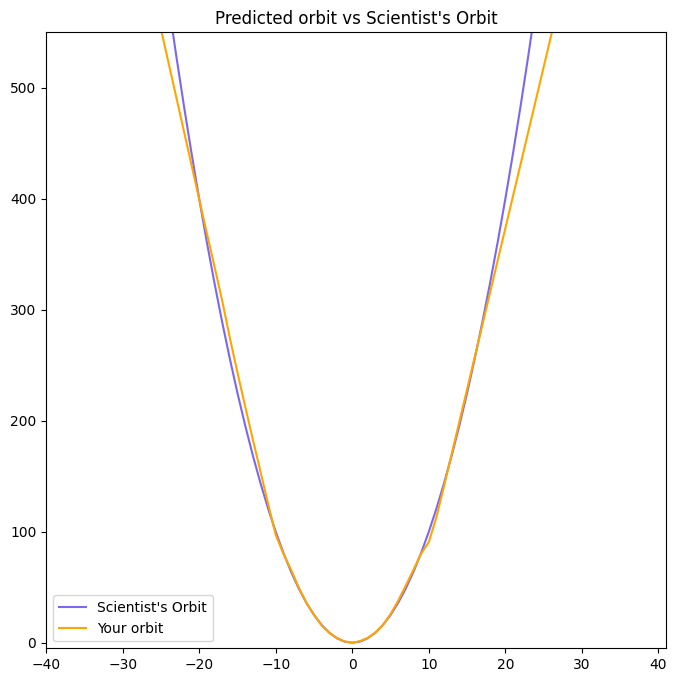

In [113]:
# Predict the eighty minute orbit
eighty_min_orbit = model.predict(np.arange(-40, 41))

# Plot the eighty minute orbit
plot_orbit(eighty_min_orbit)

# It Looks Better Than the Basic model, Let's try to use an ensemble of 400 model

In [114]:
# Utilizing Ensemble Techniques (Model Averaging)
num_models = 400
models = []
best_model = None
best_val_loss = float('inf')

for _ in range(num_models):
    # Instantiate a Sequential model
    model = Sequential()

    # Add a Dense layer with 100 neurons and an input of 1 neuron
    model.add(Dense(128, input_shape=(1,), activation='relu'))

    # Add three Dense layers with 100 neurons and relu activation
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

# End your model with a Dense layer and no activation
    model.add(Dense(1))
    early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(time_steps, y_positions, epochs=100, validation_split=0.2, callbacks=[early_stopping])

    # Store the best model based on validation loss
    if history.history['val_loss'][-1] < best_val_loss:
        best_model = model
        best_val_loss = history.history['val_loss'][-1]

    models.append(model)

Streaming output truncated to the last 5000 lines.
100/100 [==============================] - 0s 4ms/step - loss: 67.5030 - val_loss: 5.6835
Epoch 19/100
100/100 [==============================] - 0s 4ms/step - loss: 69.7504 - val_loss: 6.8834
Epoch 20/100
100/100 [==============================] - 0s 4ms/step - loss: 69.3684 - val_loss: 5.9686
Epoch 21/100
100/100 [==============================] - 0s 4ms/step - loss: 70.6476 - val_loss: 5.1741
Epoch 22/100
100/100 [==============================] - 0s 5ms/step - loss: 64.9528 - val_loss: 9.4645
Epoch 23/100
100/100 [==============================] - 1s 5ms/step - loss: 69.1158 - val_loss: 5.9985
Epoch 24/100
100/100 [==============================] - 0s 5ms/step - loss: 60.9445 - val_loss: 7.0316
Epoch 25/100
100/100 [==============================] - 1s 5ms/step - loss: 74.5876 - val_loss: 7.0257
Epoch 26/100
100/100 [==============================] - 0s 5ms/step - loss: 71.4630 - val_loss: 4.4246
Epoch 27/100
100/100 [=============

# Show All Orbits of 400 models

3/3 [==============================] - 0s 5ms/step
[<keras.src.engine.sequential.Sequential object at 0x792f7307c790>, <keras.src.engine.sequential.Sequential object at 0x792f7956de10>, <keras.src.engine.sequential.Sequential object at 0x792f7a931450>, <keras.src.engine.sequential.Sequential object at 0x792f6d2ab1c0>, <keras.src.engine.sequential.Sequential object at 0x792f7a8ccfd0>, <keras.src.engine.sequential.Sequential object at 0x792f788a95a0>, <keras.src.engine.sequential.Sequential object at 0x792f78774850>, <keras.src.engine.sequential.Sequential object at 0x792f6c9ffa60>, <keras.src.engine.sequential.Sequential object at 0x792f68c17310>, <keras.src.engine.sequential.Sequential object at 0x792f68c178e0>, <keras.src.engine.sequential.Sequential object at 0x792f6641cbe0>, <keras.src.engine.sequential.Sequential object at 0x792f786004f0>, <keras.src.engine.sequential.Sequential object at 0x792f785eada0>, <keras.src.engine.sequential.Sequential object at 0x792f7a04a410>, <keras.src

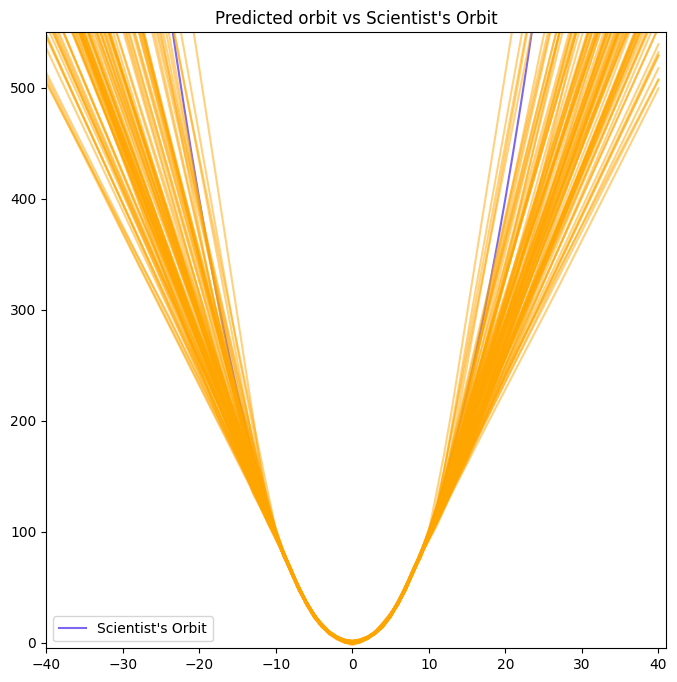

In [115]:
def plot_orbit_ensemble(model_preds_list):
    if not model_preds_list:
        print("Empty list of model predictions.")
        return

    axeslim = int(len(model_preds_list[0]) / 2)
    plt.plot(np.arange(-axeslim, axeslim + 1), np.arange(-axeslim, axeslim + 1) ** 2,
             color="mediumslateblue")

    for i, model_preds in enumerate(model_preds_list):
        plt.plot(np.arange(-axeslim, axeslim + 1), model_preds, color="orange", alpha=0.5)

    plt.axis([-40, 41, -5, 550])
    plt.legend(["Scientist's Orbit"], loc="lower left")
    plt.title("Predicted orbit vs Scientist's Orbit")

# Predict the eighty minute orbit for each model in the ensemble
ensemble_preds = [model.predict(np.arange(-40, 41)) for model in models]
print(models)

# Plot the ensemble's orbits
plot_orbit_ensemble(ensemble_preds)


# Show The Average of the ensemble Orbit

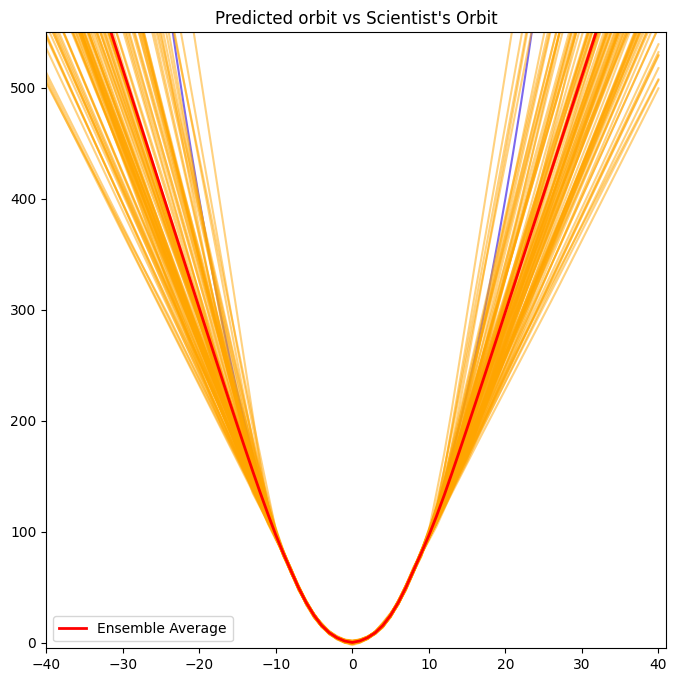

In [116]:
# Average predictions from all models in the ensemble
ensemble_avg_pred = np.mean(ensemble_preds, axis=0)

# Plot the ensemble's orbits
plot_orbit_ensemble(ensemble_preds)

# Plot the average orbit of the ensemble
plt.plot(np.arange(-40, 41), ensemble_avg_pred, color="red", linewidth=2, label="Ensemble Average")
plt.legend()
plt.show()

# Show The Best Model Orbit

3/3 [==============================] - 0s 5ms/step


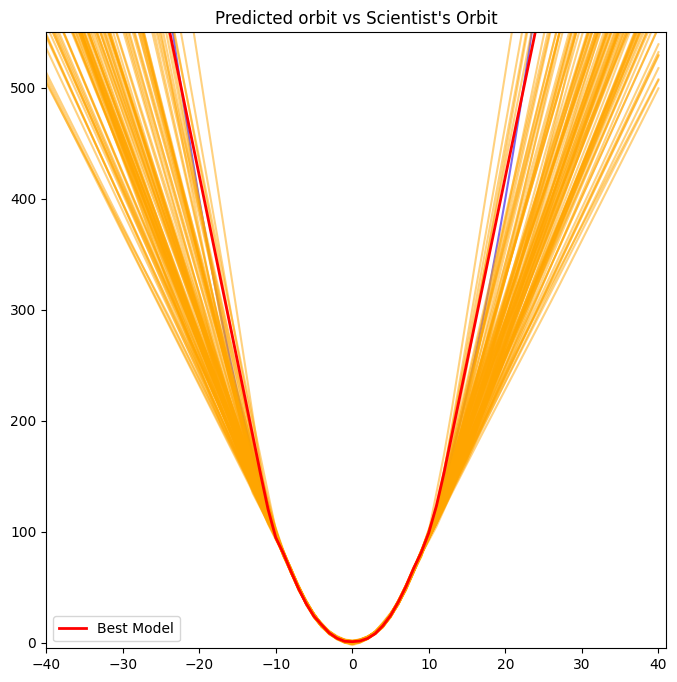

In [185]:
# Use the best model for predictions
best_model_pred = model.predict(np.arange(-40, 41))

# Plot the ensemble's orbits
plot_orbit_ensemble([modelss.predict(np.arange(-40, 41)) for modelss in models])

# Plot the prediction of the best model in red
plt.plot(np.arange(-40, 41), best_model_pred, color="red", linewidth=2, label="Best Model")
plt.legend()
plt.show()

In [186]:
# Instantiate a Sequential model
basic_model = Sequential()

# Add a Dense layer with 50 neurons and an input of 1 neuron
basic_model.add(Dense(50, input_shape=(1, ), activation='relu'))

# Add two Dense layers with 50 neurons and relu activation
basic_model.add(Dense(50, activation='relu'))
basic_model.add(Dense(50, activation='relu'))

# End your model with a Dense layer and no activation
basic_model.add(Dense(1))

basic_model.compile(optimizer='adam', loss='mse')

basic_model.fit(time_steps, y_positions, epochs=30)

Epoch 1/30
125/125 [==============================] - 1s 2ms/step - loss: 982.8438
Epoch 2/30
125/125 [==============================] - 0s 2ms/step - loss: 135.1957
Epoch 3/30
125/125 [==============================] - 0s 2ms/step - loss: 93.9175
Epoch 4/30
125/125 [==============================] - 0s 2ms/step - loss: 51.7153
Epoch 5/30
125/125 [==============================] - 0s 2ms/step - loss: 21.4781
Epoch 6/30
125/125 [==============================] - 0s 2ms/step - loss: 10.3876
Epoch 7/30
125/125 [==============================] - 0s 2ms/step - loss: 6.8260
Epoch 8/30
125/125 [==============================] - 0s 2ms/step - loss: 5.1869
Epoch 9/30
125/125 [==============================] - 0s 2ms/step - loss: 4.9793
Epoch 10/30
125/125 [==============================] - 0s 2ms/step - loss: 4.3217
Epoch 11/30
125/125 [==============================] - 0s 2ms/step - loss: 4.4344
Epoch 12/30
125/125 [==============================] - 0s 2ms/step - loss: 4.2876
Epoch 13/30
125/1

# Compare Between Basic Model Orbit, Scientist's Orbit And My Best Model Orbit

3/3 [==============================] - 0s 4ms/step


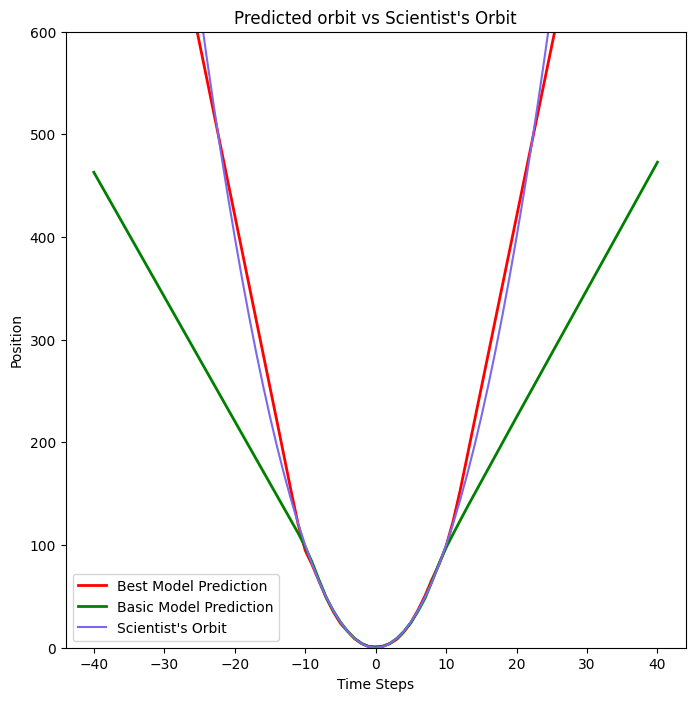

In [187]:
# Plot the best model's orbit
plt.plot(np.arange(-40, 41), best_model_pred, color="red", linewidth=2, label="Best Model Prediction")

# Plot the basic model's orbit (assuming basic_model is defined elsewhere)
plt.plot(np.arange(-40, 41), basic_model.predict(np.arange(-40, 41)), color="green", linewidth=2, label="Basic Model Prediction")

# Plot the scientific data
plt.plot(np.arange(-40, 41), np.arange(-40, 41) ** 2, color="mediumslateblue", label="Scientist's Orbit")

plt.ylim(0, 600)  # Limit y-axis to -5 to 600
plt.legend()
plt.title("Predicted orbit vs Scientist's Orbit")
plt.xlabel("Time Steps")
plt.ylabel("Position")
plt.show()